In [6]:
!pip install catboost
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 95.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=898b53eed1598208c53651fe6d9ba911460b9e4bdd9023105483c799a4441ce1
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 35.5 MB/s eta 0:00:00


In [24]:
!pip install japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from pathlib import Path
from glob import glob

from sklearn.preprocessing import LabelEncoder, StandardScaler

from catboost import CatBoost
from catboost import CatBoostRegressor
from catboost import Pool

import shap

#import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor as mor
from sklearn.metrics import mean_squared_error as MAE
from sklearn.model_selection import KFold

path_start = Path("/content/drive/MyDrive/Nishika/Mansion_2023_spring")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
train = pd.read_csv(path_start/"input/df_train.csv")
test = pd.read_csv(path_start/"input/test.csv")
sample = pd.read_csv(path_start/"input/sample_submission.csv")

df_ConCat = pd.concat([train, test])
print(df_ConCat.shape)

(784713, 29)


## 特徴量の削除

In [9]:
Fvalue = lambda x: df_ConCat.drop(x, axis=1)
List_del = ["Unnamed: 0", "取引時点", "市区町村名", "間取り", "種類", 
            "前面道路：方位", "前面道路：種類",	"前面道路：幅員（ｍ）", "地域", "土地の形状",
            "間口", "建物の構造", "延床面積（㎡）", "建築年", "用途", 
            "取引の事情等", "最寄駅：名称"]

for c in List_del:
  df_ConCat = df_ConCat.drop(c, axis=1)

## 標準化

In [10]:
List_std = ["最寄駅：距離（分）", "面積（㎡）", "建ぺい率（％）", "容積率（％）"]
scaler = StandardScaler()
scaler.fit(df_ConCat[List_std])
df_ConCat[List_std] = scaler.transform(df_ConCat[List_std])
df_ConCat.head()

,ID,市区町村コード,都道府県名,地区名,最寄駅：距離（分）,面積（㎡）,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,改装,取引価格（総額）_log
0,8067540,8217,茨城県,野々井,0.144049,0.431679,NaN,第１種住居地域,-0.741730,-0.695601,未改装,6.977724
1,8027265,8219,茨城県,ひたち野東,-0.266625,0.431679,住宅,第２種中高層住居専用地域,-0.741730,-0.695601,未改装,7.255273
2,8061526,8220,茨城県,苅間,-0.595164,1.726269,NaN,商業地域,1.177623,0.650409,未改装,7.556303
3,8086147,8220,茨城県,並木,5.236408,1.541328,NaN,第１種中高層住居専用地域,-0.741730,-0.695601,未改装,7.380211
4,8049498,8224,茨城県,ひがし野,-0.266625,1.356387,住宅,近隣商業地域,1.177623,-0.695601,未改装,7.518514


## 特徴量追加

In [11]:
for i in glob(str(path_start/"feature_value/*.csv")):
  df_ConCat = pd.merge(df_ConCat, pd.read_csv(i), on="ID")

df_ConCat.shape

(784713, 199)

## ラベルエンコーディング

In [12]:
List_Encode = []
for i, t in enumerate(df_ConCat.dtypes):
  if t!="float64" and t!="int64":
    List_Encode.append(df_ConCat.columns[i])

List_Encode    

['都道府県名',
 '地区名',
 '今後の利用目的',
 '都市計画',
 '改装',
 '市名',
 '区名',
 '郡名',
 '町名',
 '間取り_+',
 '間取り_種類',
 '利用変異',
 '最寄駅：名称',
 '運営会社',
 '路線名']

In [13]:
for c in List_Encode:
  le = LabelEncoder()
  le.fit(df_ConCat[c])
  df_ConCat[c] = le.transform(df_ConCat[c])

In [14]:
List_plus = ["用途_住宅", "用途_不明", "用途_店舗",	"用途_その他", "用途_事務所", 
             "用途_駐車場", "用途_倉庫", "用途_作業場", "用途_工場", "建物の構造_ＲＣ", 
             "建物の構造_鉄骨造", "建物の構造_ＳＲＣ", "建物の構造_不明", "建物の構造_木造", "建物の構造_軽量鉄骨造", 
             "建物の構造_ブロック造", "間取り_数字", "利用変異", "取引の事情等_不明",	"取引の事情等_調停・競売等", 
             "取引の事情等_瑕疵有りの可能性",	"取引の事情等_関係者間取引", "取引の事情等_その他事情有り", "取引の事情等_他の権利・負担付き", 
             "利用一致_不明", "利用一致_住宅", "利用一致_その他", "利用一致_事務所", "利用一致_店舗",
             "市区町村コード"]

## 分割

In [15]:
test = df_ConCat[df_ConCat["取引価格（総額）_log"].isna()==True]
train = df_ConCat[df_ConCat["取引価格（総額）_log"].isna()!=True]

In [16]:
aim = "取引価格（総額）_log"
df_y = train[aim]
df_x = train.drop([aim], axis=1)
test = test.drop([aim], axis=1)
df_x.head()

,ID,市区町村コード,都道府県名,地区名,最寄駅：距離（分）,面積（㎡）,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,...,地区名_LoE取引-建築,最寄駅：名称_LoE取引-建築,間取り_LoE取引-建築,建物の構造_LoE取引-建築,用途_LoE取引-建築,今後の利用目的_LoE取引-建築,都市計画_LoE取引-建築,取引時点_LoE取引-建築,改装_LoE取引-建築,取引の事情等_LoE取引-建築
0,8067540,8217,38,11184,0.144049,0.431679,4,10,-0.741730,-0.695601,...,4.357893e-17,4.357893e-17,4.357893e-17,4.357893e-17,4.357893e-17,4.357893e-17,4.357893e-17,4.357893e-17,4.357893e-17,4.357893e-17
1,8027265,8219,38,80,-0.266625,0.431679,2,11,-0.741730,-0.695601,...,4.357893e-17,4.357893e-17,-3.183235e-01,-3.183235e-01,-3.183235e-01,4.357893e-17,4.357893e-17,4.357893e-17,-3.183235e-01,-3.183235e-01
2,8061526,8220,38,9896,-0.595164,1.726269,4,0,1.177623,0.650409,...,4.357893e-17,4.357893e-17,-1.765825e-01,-1.765825e-01,-1.765825e-01,-3.183235e-01,4.357893e-17,4.357893e-17,-1.765825e-01,-1.765825e-01
3,8086147,8220,38,822,5.236408,1.541328,4,8,-0.741730,-0.695601,...,4.357893e-17,4.357893e-17,4.357893e-17,-4.723217e-01,-4.723217e-01,-6.653954e-01,4.357893e-17,4.357893e-17,-4.723217e-01,-4.723217e-01
4,8049498,8224,38,79,-0.266625,1.356387,2,14,1.177623,-0.695601,...,4.357893e-17,4.357893e-17,-5.455182e-01,-5.960646e-01,4.357893e-17,5.344971e-02,4.357893e-17,4.357893e-17,-5.960646e-01,-5.960646e-01


In [17]:
test.head()

,ID,市区町村コード,都道府県名,地区名,最寄駅：距離（分）,面積（㎡）,今後の利用目的,都市計画,建ぺい率（％）,容積率（％）,...,地区名_LoE取引-建築,最寄駅：名称_LoE取引-建築,間取り_LoE取引-建築,建物の構造_LoE取引-建築,用途_LoE取引-建築,今後の利用目的_LoE取引-建築,都市計画_LoE取引-建築,取引時点_LoE取引-建築,改装_LoE取引-建築,取引の事情等_LoE取引-建築
765412,1000077,1101,4,4280,-0.841569,0.616621,0,0,1.177623,1.996420,...,0.458864,0.239303,-0.071092,-0.190384,0.252481,0.194894,-0.177376,4.357893e-17,-0.137392,-0.008416
765413,1000081,1101,4,4280,-0.677299,0.616621,2,0,1.177623,1.996420,...,0.454829,0.237760,0.105223,-0.190385,0.252465,0.157717,-0.177380,-5.351911e-01,-0.137394,-0.008418
765414,1000128,1101,4,4280,-0.759434,0.061796,2,0,1.177623,0.650409,...,0.451685,0.214344,0.105216,0.384459,0.252452,0.157714,-0.177383,4.357893e-17,-0.137395,-0.008419
765415,1000129,1101,4,4280,-0.759434,-1.232794,2,0,1.177623,0.650409,...,0.454683,0.215678,0.048968,-0.190386,0.252469,0.157718,-0.177375,7.969960e-01,-0.137392,-0.008416
765416,1000130,1101,4,4280,-0.841569,0.616621,2,0,1.177623,0.650409,...,0.457233,0.216850,-0.071095,-0.190383,0.252483,0.157722,-0.177367,1.007584e+00,-0.137389,-0.008414


## 学習

In [18]:
kf = KFold(n_splits=5, shuffle=True, random_state=71)

models = []

# ハイパーパラメータの調整
"""
params = {'boosting_type': 'gbdt', 
          "objective": "regression_l1", 
          "num_round":100, 
          "learning_rate": 0.2,
          "reg_alpha": 0.1,
          "reg_lambda": 0.1,
          "random_state": 71,
          "max_depth": 5,
          "n_estimators": 1000, 
          "colsample_bytree": 1.0,
          "colsample_bylevel": 0.3,
          "lambda_l1": 0.0001,
          'metrics': 'mae', 
          'learning_rate': 0.1}
"""

'\nparams = {\'boosting_type\': \'gbdt\', \n          "objective": "regression_l1", \n          "num_round":100, \n          "learning_rate": 0.2,\n          "reg_alpha": 0.1,\n          "reg_lambda": 0.1,\n          "random_state": 71,\n          "max_depth": 5,\n          "n_estimators": 1000, \n          "colsample_bytree": 1.0,\n          "colsample_bylevel": 0.3,\n          "lambda_l1": 0.0001,\n          \'metrics\': \'mae\', \n          \'learning_rate\': 0.1}\n'

In [19]:
scores = []
Preds = []
models = []
i = 0
for tr_idx, va_idx in kf.split(df_x):
  i += 1
  print("{}回目".format(i))
  x_df_train, x_df_val = df_x.iloc[tr_idx], df_x.iloc[va_idx]
  y_df_train, y_df_val = df_y.iloc[tr_idx], df_y.iloc[va_idx]
  pool_train = Pool(x_df_train, y_df_train)
  pool_val = Pool(x_df_val, y_df_val)

  evaluation_results = {}
  model = CatBoostRegressor(early_stopping_rounds=20, 
                            eval_metric="MAE", 
                            learning_rate=0.1, 
                            depth=5, 
                            random_seed=71, 
                            )
  cab = model.fit(pool_train)

  va_pred = cab.predict(x_df_val)
  score = MAE(np.array(y_df_val), va_pred, squared=False)
  scores.append(score)

  models.append(cab)
print(f'MAE: {np.mean(scores):.4f}')
print(scores)

ストリーミング出力は最後の 5000 行に切り捨てられました。
6:	learn: 0.1846965	total: 3.55s	remaining: 8m 23s
7:	learn: 0.1774326	total: 3.9s	remaining: 8m 4s
8:	learn: 0.1710026	total: 4.21s	remaining: 7m 43s
9:	learn: 0.1652766	total: 4.56s	remaining: 7m 31s
10:	learn: 0.1603652	total: 4.9s	remaining: 7m 20s
11:	learn: 0.1558247	total: 5.2s	remaining: 7m 7s
12:	learn: 0.1520151	total: 5.51s	remaining: 6m 58s
13:	learn: 0.1486119	total: 5.79s	remaining: 6m 47s
14:	learn: 0.1451865	total: 6.06s	remaining: 6m 38s
15:	learn: 0.1420315	total: 6.38s	remaining: 6m 32s
16:	learn: 0.1392065	total: 6.67s	remaining: 6m 25s
17:	learn: 0.1368494	total: 6.95s	remaining: 6m 19s
18:	learn: 0.1345404	total: 7.25s	remaining: 6m 14s
19:	learn: 0.1327263	total: 7.54s	remaining: 6m 9s
20:	learn: 0.1307039	total: 7.81s	remaining: 6m 4s
21:	learn: 0.1289690	total: 8.05s	remaining: 5m 57s
22:	learn: 0.1273589	total: 8.28s	remaining: 5m 51s
23:	learn: 0.1259268	total: 8.55s	remaining: 5m 47s
24:	learn: 0.1245817	total: 8.8s	remaining:

In [20]:
# 予測値を保存するデータフレームの初期化
df_preds = pd.DataFrame()

# 保存してあるモデルで予測
for i, model in enumerate(models):
    y_pred = model.predict(test)
    df_preds[i] = y_pred

 # 保存した予測値を表示   
df_preds.head()    

,0,1,2,3,4
0,7.568903,7.573763,7.559949,7.593818,7.557928
1,7.603210,7.611187,7.599541,7.606084,7.586834
2,6.995362,6.992614,7.003015,7.056572,6.978238
3,6.622580,6.616392,6.595713,6.620305,6.594755
4,7.636389,7.621357,7.607092,7.641164,7.603920


In [21]:
FileName = "sub_CatBoost_02_mean"

sample[aim] = df_preds.mean(axis=1)
sample.to_csv(path_start/"output/{}.csv".format(FileName), index = False)
pd.read_csv(path_start/"output/{}.csv".format(FileName))

,ID,取引価格（総額）_log
0,1000077,7.570872
1,1000081,7.601371
2,1000128,7.005160
3,1000129,6.609949
4,1000130,7.621985
...,...,...
19296,47006020,7.501304
19297,47006229,7.493141
19298,47006331,7.473050
19299,47006332,7.179978


## shap

In [22]:
exp = shap.TreeExplainer(models[0])
sv_test = exp.shap_values(test)
print(test.shape, sv_test.shape)

(19301, 198) (19301, 198)


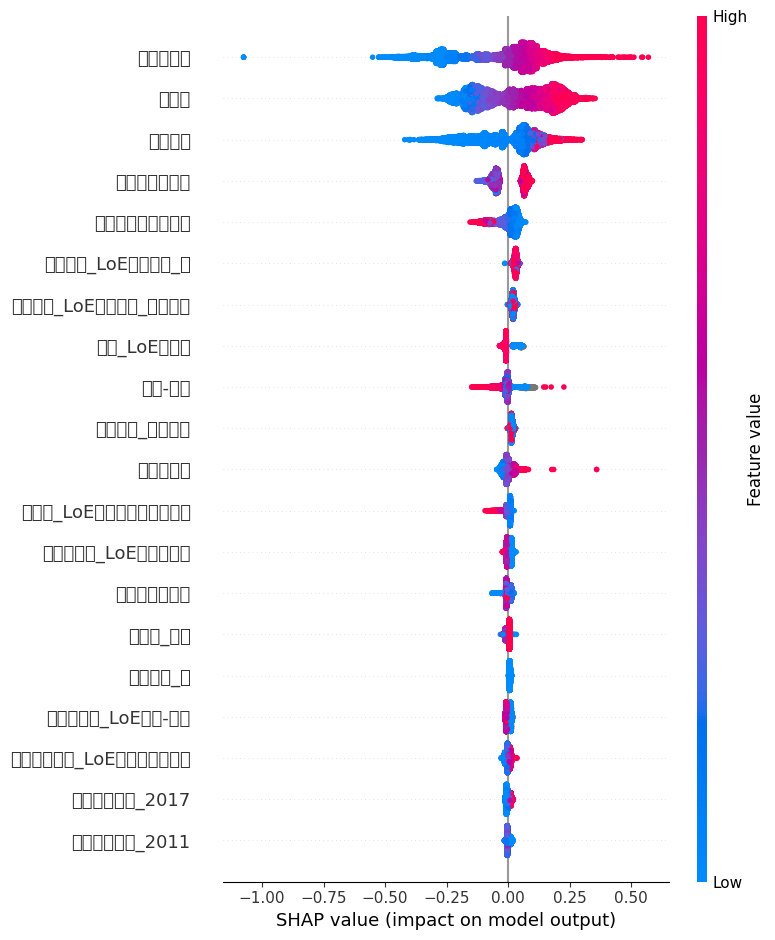

In [25]:
shap.summary_plot(sv_test, test)